In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

In [6]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB16 as SCB
from omegaconf import OmegaConf as ocf

In [7]:
dataset_name = 'crema_d'
experiment_prefix = "scb16"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
data_dir = "../data/data_preprocessed/"
dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
batch_size = 4

{'name': 'crema_d', 'dataset_class': 'WaveformDataset', 'root': 'crema_d/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label6', 'feature_name': 'audio16k', 'num_classes': 6, 'label_values': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'classnames': ['neu', 'hap', 'sad', 'ang', 'fea', 'dis'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [8]:
in_channels = 1
out_channels = 8
embedding_dim = 1023
num_embeddings = 384
commitment_cost = 0.25
learning_rate = 1e-4
num_tokens = 256
num_classes = 4

In [9]:
iconnet_config_path = f'config/model/m19win.yaml'
iconnet_config = ocf.load(iconnet_config_path)
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [256], 'kernel_size': [511], 'stride': [2], 'window_k': [5], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


In [10]:
codebook_pretrained_path = f'../scb7_models/crema_d/codebook.epoch=42.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [11]:
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)

In [12]:
loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=1, loss_recon=1, loss_cls=1)
trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)
trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

In [13]:
trainer.setup(model=model, lr=learning_rate)

In [14]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▍                                                                               | 0.4771622934888197/100 [03:24<191:11:29, 6915.89s/it]

Epoch: 1	Loss: 0.949 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.949]	Val_acc: 96/196 (48.98%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=1.step=368.loss=0.949.val_acc=0.490.pt


  1%|█▏                                                                                  | 1.428571428571455/100 [08:35<7:22:22, 269.27s/it]

Correct: 388/980 (0.3959)
Saved new best test model: ../scb16_models/crema_d/model.epoch=1.step=735.test_acc=0.3959.pt
{'acc_unweighted': tensor(0.4162, device='cuda:0'),
 'acc_weighted': tensor(0.3959, device='cuda:0'),
 'f1s_unweighted': tensor(0.3378, device='cuda:0'),
 'f1s_weighted': tensor(0.3328, device='cuda:0'),
 'rocauc': tensor(0.7916, device='cuda:0'),
 'uar': tensor(0.4162, device='cuda:0'),
 'wap': tensor(0.3790, device='cuda:0')}
{'acc_detail': tensor([0.4291, 0.9679, 0.0000, 0.2677], device='cuda:0'),
 'f1s_detail': tensor([0.5547, 0.4726, 0.0000, 0.3238], device='cuda:0'),
 'precision_detail': tensor([0.7842, 0.3126, 0.0000, 0.4096], device='cuda:0'),
 'recall_detail': tensor([0.4291, 0.9679, 0.0000, 0.2677], device='cuda:0'),
 'rocauc_detail': tensor([0.8939, 0.6791, 0.8981, 0.6954], device='cuda:0')}
tensor([[109,  57,   0,  88],
        [  0, 211,   0,   7],
        [  0, 251,   0,   3],
        [ 30, 156,   0,  68]], device='cuda:0')


  2%|█▌                                                                              | 1.9057337220602952/100 [12:00<185:09:28, 6795.19s/it]

Epoch: 2	Loss: 0.719 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.719]	Val_acc: 99/196 (50.51%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=2.step=1103.loss=0.719.val_acc=0.505.pt


  3%|██▎                                                                             | 2.8581146744412798/100 [18:25<190:02:58, 7043.08s/it]

Epoch: 3	Loss: 1.314 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.314]	Val_acc: 124/196 (63.27%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=3.step=1838.loss=1.314.val_acc=0.633.pt


  4%|███                                                                             | 3.8104956268222643/100 [24:50<184:36:10, 6908.97s/it]

Epoch: 4	Loss: 1.107 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.107]	Val_acc: 117/196 (59.69%)



  5%|███▊                                                                             | 4.762876579203248/100 [31:14<184:20:41, 6968.31s/it]

Epoch: 5	Loss: 1.036 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.036]	Val_acc: 127/196 (64.80%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=5.step=3308.loss=1.036.val_acc=0.648.pt


  6%|████▋                                                                            | 5.715257531584233/100 [37:40<183:29:40, 7006.22s/it]

Epoch: 6	Loss: 0.813 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.813]	Val_acc: 130/196 (66.33%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=6.step=4043.loss=0.813.val_acc=0.663.pt


  7%|█████▍                                                                           | 6.667638483965217/100 [44:06<181:01:20, 6982.37s/it]

Epoch: 7	Loss: 0.271 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.271]	Val_acc: 113/196 (57.65%)



  8%|██████▏                                                                          | 7.620019436346202/100 [50:32<179:43:07, 7003.55s/it]

Epoch: 8	Loss: 0.428 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.428]	Val_acc: 133/196 (67.86%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=8.step=5513.loss=0.428.val_acc=0.679.pt


  9%|██████▉                                                                          | 8.572400388727186/100 [56:59<176:57:49, 6968.02s/it]

Epoch: 9	Loss: 0.553 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.553]	Val_acc: 133/196 (67.86%)



 10%|███████▌                                                                        | 9.52478134110817/100 [1:03:26<175:35:17, 6986.64s/it]

Epoch: 10	Loss: 0.586 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.586]	Val_acc: 118/196 (60.20%)



 10%|████████▏                                                                     | 10.477162293489155/100 [1:09:54<172:25:10, 6933.54s/it]

Epoch: 11	Loss: 1.133 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.133]	Val_acc: 130/196 (66.33%)



 11%|█████████▎                                                                       | 11.428571428571791/100 [1:15:09<6:44:33, 274.06s/it]

Correct: 595/980 (0.6071)
Saved new best test model: ../scb16_models/crema_d/model.epoch=11.step=8085.test_acc=0.6071.pt
{'acc_unweighted': tensor(0.6033, device='cuda:0'),
 'acc_weighted': tensor(0.6071, device='cuda:0'),
 'f1s_unweighted': tensor(0.6000, device='cuda:0'),
 'f1s_weighted': tensor(0.6038, device='cuda:0'),
 'rocauc': tensor(0.8516, device='cuda:0'),
 'uar': tensor(0.6033, device='cuda:0'),
 'wap': tensor(0.6075, device='cuda:0')}
{'acc_detail': tensor([0.6457, 0.5000, 0.8071, 0.4606], device='cuda:0'),
 'f1s_detail': tensor([0.6949, 0.4966, 0.7231, 0.4855], device='cuda:0'),
 'precision_detail': tensor([0.7523, 0.4932, 0.6550, 0.5132], device='cuda:0'),
 'recall_detail': tensor([0.6457, 0.5000, 0.8071, 0.4606], device='cuda:0'),
 'rocauc_detail': tensor([0.9083, 0.8200, 0.9138, 0.7644], device='cuda:0')}
tensor([[164,  11,   4,  75],
        [  0, 109,  85,  24],
        [  1,  36, 205,  12],
        [ 53,  65,  19, 117]], device='cuda:0')


 12%|█████████▎                                                                    | 11.905733722060631/100 [1:18:35<173:07:39, 7074.92s/it]

Epoch: 12	Loss: 0.872 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.872]	Val_acc: 125/196 (63.78%)



 13%|██████████                                                                    | 12.858114674441616/100 [1:25:02<169:42:42, 7011.12s/it]

Epoch: 13	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 114/196 (58.16%)



 14%|███████████                                                                     | 13.8104956268226/100 [1:31:31<168:46:06, 7049.19s/it]

Epoch: 14	Loss: 0.933 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.933]	Val_acc: 124/196 (63.27%)



 15%|███████████▌                                                                  | 14.762876579203585/100 [1:38:00<167:22:14, 7068.92s/it]

Epoch: 15	Loss: 0.483 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.483]	Val_acc: 124/196 (63.27%)



 16%|████████████▍                                                                  | 15.71525753158457/100 [1:44:30<164:13:26, 7014.39s/it]

Epoch: 16	Loss: 0.172 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.172]	Val_acc: 131/196 (66.84%)



 17%|█████████████                                                                 | 16.667638483964332/100 [1:50:58<162:36:36, 7024.84s/it]

Epoch: 17	Loss: 0.708 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.708]	Val_acc: 126/196 (64.29%)



 18%|█████████████▋                                                                | 17.620019436343576/100 [1:57:27<161:24:31, 7053.55s/it]

Epoch: 18	Loss: 0.142 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.142]	Val_acc: 129/196 (65.82%)



 19%|██████████████▋                                                                | 18.57240038872282/100 [2:03:55<158:44:03, 7017.81s/it]

Epoch: 19	Loss: 0.906 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.906]	Val_acc: 122/196 (62.24%)



 20%|███████████████▏                                                              | 19.524781341102063/100 [2:10:25<157:17:03, 7036.00s/it]

Epoch: 20	Loss: 0.281 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.281]	Val_acc: 120/196 (61.22%)



 20%|███████████████▉                                                              | 20.477162293481307/100 [2:16:55<155:29:36, 7039.19s/it]

Epoch: 21	Loss: 0.862 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.862]	Val_acc: 124/196 (63.27%)



 21%|█████████████████▎                                                               | 21.428571428562204/100 [2:22:12<6:02:44, 277.00s/it]

Correct: 560/980 (0.5714)
{'acc_unweighted': tensor(0.5744, device='cuda:0'),
 'acc_weighted': tensor(0.5714, device='cuda:0'),
 'f1s_unweighted': tensor(0.5635, device='cuda:0'),
 'f1s_weighted': tensor(0.5641, device='cuda:0'),
 'rocauc': tensor(0.8301, device='cuda:0'),
 'uar': tensor(0.5744, device='cuda:0'),
 'wap': tensor(0.6125, device='cuda:0')}
{'acc_detail': tensor([0.8189, 0.6560, 0.4252, 0.3976], device='cuda:0'),
 'f1s_detail': tensor([0.7051, 0.5458, 0.5714, 0.4316], device='cuda:0'),
 'precision_detail': tensor([0.6190, 0.4673, 0.8710, 0.4720], device='cuda:0'),
 'recall_detail': tensor([0.8189, 0.6560, 0.4252, 0.3976], device='cuda:0'),
 'rocauc_detail': tensor([0.8990, 0.8082, 0.8701, 0.7431], device='cuda:0')}
tensor([[208,   8,   1,  37],
        [ 17, 143,  12,  46],
        [  7, 109, 108,  30],
        [104,  46,   3, 101]], device='cuda:0')


 22%|█████████████████                                                             | 21.905733722050172/100 [2:25:38<152:19:21, 7021.80s/it]

Epoch: 22	Loss: 0.221 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.221]	Val_acc: 121/196 (61.73%)



 23%|█████████████████▊                                                            | 22.858114674429416/100 [2:32:07<150:25:26, 7019.88s/it]

Epoch: 23	Loss: 0.376 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.376]	Val_acc: 121/196 (61.73%)



 24%|██████████████████▊                                                            | 23.81049562680866/100 [2:38:36<149:56:52, 7085.13s/it]

Epoch: 24	Loss: 0.151 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.151]	Val_acc: 124/196 (63.27%)



 25%|███████████████████▎                                                          | 24.762876579187903/100 [2:45:06<146:22:59, 7004.24s/it]

Epoch: 25	Loss: 0.038 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.038]	Val_acc: 129/196 (65.82%)



 26%|████████████████████                                                          | 25.715257531567147/100 [2:51:36<145:22:40, 7045.32s/it]

Epoch: 26	Loss: 0.087 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.087]	Val_acc: 126/196 (64.29%)



 27%|█████████████████████                                                          | 26.66763848394639/100 [2:58:06<143:57:00, 7066.73s/it]

Epoch: 27	Loss: 0.013 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.013]	Val_acc: 125/196 (63.78%)



 28%|█████████████████████▌                                                        | 27.620019436325634/100 [3:04:37<141:14:20, 7024.88s/it]

Epoch: 28	Loss: 0.532 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.532]	Val_acc: 120/196 (61.22%)



 29%|██████████████████████▎                                                       | 28.572400388704878/100 [3:11:09<139:58:49, 7055.11s/it]

Epoch: 29	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 125/196 (63.78%)



 30%|███████████████████████                                                       | 29.524781341084122/100 [3:17:40<138:06:21, 7054.70s/it]

Epoch: 30	Loss: 0.014 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.014]	Val_acc: 121/196 (61.73%)



 30%|███████████████████████▊                                                      | 30.477162293463365/100 [3:24:12<136:57:32, 7091.95s/it]

Epoch: 31	Loss: 0.776 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.776]	Val_acc: 113/196 (57.65%)



 31%|█████████████████████████▍                                                       | 31.428571428544263/100 [3:29:30<5:22:01, 281.77s/it]

Correct: 598/980 (0.6102)
Saved new best test model: ../scb16_models/crema_d/model.epoch=31.step=22785.test_acc=0.6102.pt
{'acc_unweighted': tensor(0.6086, device='cuda:0'),
 'acc_weighted': tensor(0.6102, device='cuda:0'),
 'f1s_unweighted': tensor(0.6097, device='cuda:0'),
 'f1s_weighted': tensor(0.6121, device='cuda:0'),
 'rocauc': tensor(0.8442, device='cuda:0'),
 'uar': tensor(0.6086, device='cuda:0'),
 'wap': tensor(0.6182, device='cuda:0')}
{'acc_detail': tensor([0.6063, 0.5642, 0.7441, 0.5197], device='cuda:0'),
 'f1s_detail': tensor([0.6667, 0.5467, 0.7228, 0.5029], device='cuda:0'),
 'precision_detail': tensor([0.7404, 0.5302, 0.7026, 0.4871], device='cuda:0'),
 'recall_detail': tensor([0.6063, 0.5642, 0.7441, 0.5197], device='cuda:0'),
 'rocauc_detail': tensor([0.8958, 0.8227, 0.8956, 0.7626], device='cuda:0')}
tensor([[154,  12,   5,  83],
        [  3, 123,  58,  34],
        [  1,  42, 189,  22],
        [ 50,  55,  17, 132]], device='cuda:0')


 32%|█████████████████████████▏                                                     | 31.90573372203223/100 [3:32:57<132:59:07, 7030.66s/it]

Epoch: 32	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 120/196 (61.22%)



 33%|█████████████████████████▉                                                     | 32.85811467441461/100 [3:39:30<132:38:01, 7111.53s/it]

Epoch: 33	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 115/196 (58.67%)



 34%|██████████████████████████▎                                                   | 33.810495626797334/100 [3:46:03<132:13:24, 7191.55s/it]

Epoch: 34	Loss: 0.013 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.013]	Val_acc: 117/196 (59.69%)



 35%|███████████████████████████▍                                                   | 34.76287657918006/100 [3:52:36<128:21:09, 7082.93s/it]

Epoch: 35	Loss: 0.293 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.293]	Val_acc: 108/196 (55.10%)



 36%|███████████████████████████▊                                                  | 35.715257531562784/100 [3:59:11<127:01:21, 7113.37s/it]

Epoch: 36	Loss: 0.525 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.525]	Val_acc: 122/196 (62.24%)



 37%|████████████████████████████▉                                                  | 36.66763848394551/100 [4:05:46<124:32:11, 7079.02s/it]

Epoch: 37	Loss: 0.066 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.066]	Val_acc: 118/196 (60.20%)



 38%|█████████████████████████████▎                                                | 37.620019436328235/100 [4:12:19<120:15:18, 6940.03s/it]

Epoch: 38	Loss: 0.138 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.138]	Val_acc: 116/196 (59.18%)



 39%|██████████████████████████████▍                                                | 38.57240038871096/100 [4:18:53<122:08:33, 7158.24s/it]

Epoch: 39	Loss: 0.104 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.104]	Val_acc: 109/196 (55.61%)



 40%|██████████████████████████████▊                                               | 39.524781341093686/100 [4:25:28<119:45:11, 7128.73s/it]

Epoch: 40	Loss: 0.039 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.039]	Val_acc: 121/196 (61.73%)



 40%|███████████████████████████████▉                                               | 40.47716229347641/100 [4:32:03<117:30:38, 7107.17s/it]

Epoch: 41	Loss: 0.012 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.012]	Val_acc: 119/196 (60.71%)



 41%|█████████████████████████████████▉                                                | 41.42857142856079/100 [4:37:25<4:36:08, 282.87s/it]

Correct: 588/980 (0.6000)
{'acc_unweighted': tensor(0.5987, device='cuda:0'),
 'acc_weighted': tensor(0.6000, device='cuda:0'),
 'f1s_unweighted': tensor(0.5974, device='cuda:0'),
 'f1s_weighted': tensor(0.5998, device='cuda:0'),
 'rocauc': tensor(0.8367, device='cuda:0'),
 'uar': tensor(0.5987, device='cuda:0'),
 'wap': tensor(0.6019, device='cuda:0')}
{'acc_detail': tensor([0.7323, 0.5642, 0.6457, 0.4528], device='cuda:0'),
 'f1s_detail': tensor([0.7086, 0.5336, 0.6791, 0.4684], device='cuda:0'),
 'precision_detail': tensor([0.6863, 0.5062, 0.7162, 0.4852], device='cuda:0'),
 'recall_detail': tensor([0.7323, 0.5642, 0.6457, 0.4528], device='cuda:0'),
 'rocauc_detail': tensor([0.8981, 0.8230, 0.8885, 0.7371], device='cuda:0')}
tensor([[186,  12,   3,  53],
        [  8, 123,  46,  41],
        [  1,  61, 164,  28],
        [ 76,  47,  16, 115]], device='cuda:0')


 42%|█████████████████████████████████▌                                              | 41.9057337220505/100 [4:40:54<114:19:03, 7084.07s/it]

Epoch: 42	Loss: 0.005 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.005]	Val_acc: 120/196 (61.22%)



 43%|█████████████████████████████████▍                                            | 42.858114674433224/100 [4:47:28<113:04:22, 7123.72s/it]

Epoch: 43	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 124/196 (63.27%)



 44%|██████████████████████████████████▌                                            | 43.81049562681595/100 [4:54:04<111:27:51, 7141.40s/it]

Epoch: 44	Loss: 0.010 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.010]	Val_acc: 115/196 (58.67%)



 45%|██████████████████████████████████▉                                           | 44.762876579198675/100 [5:00:40<110:37:13, 7209.53s/it]

Epoch: 45	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 109/196 (55.61%)



 46%|████████████████████████████████████▌                                           | 45.7152575315814/100 [5:07:16<108:14:52, 7178.68s/it]

Epoch: 46	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 124/196 (63.27%)



 47%|████████████████████████████████████▍                                         | 46.667638483964126/100 [5:13:53<105:59:01, 7154.04s/it]

Epoch: 47	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 118/196 (60.20%)



 48%|█████████████████████████████████████▌                                         | 47.62001943634685/100 [5:20:29<103:31:40, 7115.33s/it]

Epoch: 48	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 110/196 (56.12%)



 49%|██████████████████████████████████████▎                                        | 48.57240038872958/100 [5:27:07<103:03:50, 7214.62s/it]

Epoch: 49	Loss: 0.053 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.053]	Val_acc: 124/196 (63.27%)



 50%|███████████████████████████████████████▌                                        | 49.5247813411123/100 [5:33:46<100:11:05, 7145.40s/it]

Epoch: 50	Loss: 0.396 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.396]	Val_acc: 117/196 (59.69%)



 50%|████████████████████████████████████████▍                                       | 50.47716229349503/100 [5:40:24<98:12:04, 7138.62s/it]

Epoch: 51	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 120/196 (61.22%)



 51%|██████████████████████████████████████████▋                                        | 51.4285714285794/100 [5:45:50<3:52:31, 287.23s/it]

Correct: 578/980 (0.5898)
{'acc_unweighted': tensor(0.5908, device='cuda:0'),
 'acc_weighted': tensor(0.5898, device='cuda:0'),
 'f1s_unweighted': tensor(0.5933, device='cuda:0'),
 'f1s_weighted': tensor(0.5944, device='cuda:0'),
 'rocauc': tensor(0.8334, device='cuda:0'),
 'uar': tensor(0.5908, device='cuda:0'),
 'wap': tensor(0.6227, device='cuda:0')}
{'acc_detail': tensor([0.6969, 0.6193, 0.5079, 0.5394], device='cuda:0'),
 'f1s_detail': tensor([0.6874, 0.5637, 0.6293, 0.4928], device='cuda:0'),
 'precision_detail': tensor([0.6782, 0.5172, 0.8269, 0.4536], device='cuda:0'),
 'recall_detail': tensor([0.6969, 0.6193, 0.5079, 0.5394], device='cuda:0'),
 'rocauc_detail': tensor([0.8928, 0.8227, 0.8875, 0.7305], device='cuda:0')}
tensor([[177,   8,   2,  67],
        [  9, 135,  16,  58],
        [  3,  82, 129,  40],
        [ 72,  36,   9, 137]], device='cuda:0')


 52%|█████████████████████████████████████████                                      | 51.905733722069115/100 [5:49:20<95:40:16, 7161.27s/it]

Epoch: 52	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 119/196 (60.71%)



 53%|██████████████████████████████████████████▎                                     | 52.85811467445184/100 [5:55:59<93:46:34, 7161.24s/it]

Epoch: 53	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 118/196 (60.20%)



 54%|██████████████████████████████████████████▌                                    | 53.810495626834566/100 [6:02:37<91:50:47, 7158.50s/it]

Epoch: 54	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 126/196 (64.29%)



 55%|███████████████████████████████████████████▊                                    | 54.76287657921729/100 [6:09:21<92:52:59, 7391.70s/it]

Epoch: 55	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 120/196 (61.22%)



 56%|████████████████████████████████████████████▌                                   | 55.71525753160002/100 [6:16:20<92:39:24, 7532.27s/it]

Epoch: 56	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 113/196 (57.65%)



 57%|█████████████████████████████████████████████▎                                  | 56.66763848398274/100 [6:23:17<90:44:49, 7539.16s/it]

Epoch: 57	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 119/196 (60.71%)



 58%|██████████████████████████████████████████████                                  | 57.62001943636547/100 [6:30:16<89:07:41, 7571.06s/it]

Epoch: 58	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 120/196 (61.22%)



 59%|██████████████████████████████████████████████▊                                 | 58.57240038874819/100 [6:37:15<86:18:39, 7500.29s/it]

Epoch: 59	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 121/196 (61.73%)



 60%|███████████████████████████████████████████████▌                                | 59.52478134113092/100 [6:44:12<84:11:41, 7488.56s/it]

Epoch: 60	Loss: 0.075 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.075]	Val_acc: 119/196 (60.71%)



 60%|████████████████████████████████████████████████▍                               | 60.47716229351364/100 [6:51:10<82:07:23, 7480.33s/it]

Epoch: 61	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 120/196 (61.22%)



 61%|██████████████████████████████████████████████████▎                               | 61.42857142859802/100 [6:56:48<3:10:28, 296.31s/it]

Correct: 592/980 (0.6041)
{'acc_unweighted': tensor(0.6045, device='cuda:0'),
 'acc_weighted': tensor(0.6041, device='cuda:0'),
 'f1s_unweighted': tensor(0.6083, device='cuda:0'),
 'f1s_weighted': tensor(0.6096, device='cuda:0'),
 'rocauc': tensor(0.8366, device='cuda:0'),
 'uar': tensor(0.6045, device='cuda:0'),
 'wap': tensor(0.6291, device='cuda:0')}
{'acc_detail': tensor([0.6693, 0.6147, 0.5669, 0.5669], device='cuda:0'),
 'f1s_detail': tensor([0.6827, 0.5726, 0.6636, 0.5143], device='cuda:0'),
 'precision_detail': tensor([0.6967, 0.5360, 0.8000, 0.4706], device='cuda:0'),
 'recall_detail': tensor([0.6693, 0.6147, 0.5669, 0.5669], device='cuda:0'),
 'rocauc_detail': tensor([0.8926, 0.8299, 0.8835, 0.7405], device='cuda:0')}
tensor([[170,   8,   2,  74],
        [  6, 134,  22,  56],
        [  3,  75, 144,  32],
        [ 65,  33,  12, 144]], device='cuda:0')


 62%|█████████████████████████████████████████████████▌                              | 61.90573372208773/100 [7:00:30<79:47:19, 7540.24s/it]

Epoch: 62	Loss: 0.066 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.066]	Val_acc: 98/196 (50.00%)



 63%|██████████████████████████████████████████████████▎                             | 62.85811467447046/100 [7:07:29<78:49:40, 7640.44s/it]

Epoch: 63	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 117/196 (59.69%)



 64%|███████████████████████████████████████████████████                             | 63.81049562685318/100 [7:14:30<75:38:53, 7525.20s/it]

Epoch: 64	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 119/196 (60.71%)



 65%|███████████████████████████████████████████████████▊                            | 64.76287657923591/100 [7:21:30<72:12:55, 7377.90s/it]

Epoch: 65	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 117/196 (59.69%)



 66%|████████████████████████████████████████████████████▌                           | 65.71525753161863/100 [7:28:30<71:05:00, 7463.96s/it]

Epoch: 66	Loss: 0.520 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.520]	Val_acc: 119/196 (60.71%)



 67%|█████████████████████████████████████████████████████▎                          | 66.66763848400136/100 [7:35:33<69:48:41, 7539.86s/it]

Epoch: 67	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 121/196 (61.73%)



 68%|██████████████████████████████████████████████████████                          | 67.62001943638408/100 [7:42:34<68:05:42, 7570.79s/it]

Epoch: 68	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 123/196 (62.76%)



 69%|██████████████████████████████████████████████████████▊                         | 68.57240038876681/100 [7:49:36<65:56:28, 7553.50s/it]

Epoch: 69	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 116/196 (59.18%)



 70%|███████████████████████████████████████████████████████▌                        | 69.52478134114953/100 [7:56:40<64:11:42, 7583.29s/it]

Epoch: 70	Loss: 0.040 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.040]	Val_acc: 118/196 (60.20%)



 70%|████████████████████████████████████████████████████████▍                       | 70.47716229353226/100 [8:03:42<62:31:15, 7623.79s/it]

Epoch: 71	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 125/196 (63.78%)



 71%|██████████████████████████████████████████████████████████▌                       | 71.42857142861664/100 [8:09:23<2:20:41, 295.44s/it]

Correct: 600/980 (0.6122)
Saved new best test model: ../scb16_models/crema_d/model.epoch=71.step=52185.test_acc=0.6122.pt
{'acc_unweighted': tensor(0.6117, device='cuda:0'),
 'acc_weighted': tensor(0.6122, device='cuda:0'),
 'f1s_unweighted': tensor(0.6114, device='cuda:0'),
 'f1s_weighted': tensor(0.6127, device='cuda:0'),
 'rocauc': tensor(0.8291, device='cuda:0'),
 'uar': tensor(0.6117, device='cuda:0'),
 'wap': tensor(0.6217, device='cuda:0')}
{'acc_detail': tensor([0.7638, 0.5963, 0.5906, 0.4961], device='cuda:0'),
 'f1s_detail': tensor([0.7106, 0.5740, 0.6696, 0.4912], device='cuda:0'),
 'precision_detail': tensor([0.6644, 0.5532, 0.7732, 0.4865], device='cuda:0'),
 'recall_detail': tensor([0.7638, 0.5963, 0.5906, 0.4961], device='cuda:0'),
 'rocauc_detail': tensor([0.8955, 0.8304, 0.8857, 0.7048], device='cuda:0')}
tensor([[194,  10,   1,  49],
        [  7, 130,  28,  53],
        [  4,  69, 150,  31],
        [ 87,  26,  15, 126]], device='cuda:0')


 72%|█████████████████████████████████████████████████████████▌                      | 71.90573372210635/100 [8:13:07<58:54:18, 7548.10s/it]

Epoch: 72	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 124/196 (63.27%)



 73%|██████████████████████████████████████████████████████████▎                     | 72.85811467448907/100 [8:20:10<56:57:29, 7554.71s/it]

Epoch: 73	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 123/196 (62.76%)



 74%|███████████████████████████████████████████████████████████▊                     | 73.8104956268718/100 [8:27:13<54:50:02, 7537.46s/it]

Epoch: 74	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 122/196 (62.24%)



 75%|███████████████████████████████████████████████████████████▊                    | 74.76287657925452/100 [8:34:15<53:27:54, 7626.65s/it]

Epoch: 75	Loss: 0.013 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.013]	Val_acc: 126/196 (64.29%)



 76%|████████████████████████████████████████████████████████████▌                   | 75.71525753163725/100 [8:41:18<51:15:16, 7598.03s/it]

Epoch: 76	Loss: 0.397 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.397]	Val_acc: 119/196 (60.71%)



 77%|█████████████████████████████████████████████████████████████▎                  | 76.66763848401997/100 [8:48:21<49:13:23, 7594.73s/it]

Epoch: 77	Loss: 0.106 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.106]	Val_acc: 116/196 (59.18%)



 78%|██████████████████████████████████████████████████████████████▊                  | 77.6200194364027/100 [8:55:25<47:47:35, 7687.91s/it]

Epoch: 78	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 117/196 (59.69%)



 79%|██████████████████████████████████████████████████████████████▊                 | 78.57240038878543/100 [9:02:28<45:02:58, 7568.67s/it]

Epoch: 79	Loss: 0.022 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.022]	Val_acc: 117/196 (59.69%)



 80%|███████████████████████████████████████████████████████████████▌                | 79.52478134116815/100 [9:09:33<43:13:22, 7599.54s/it]

Epoch: 80	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 123/196 (62.76%)



 80%|████████████████████████████████████████████████████████████████▍               | 80.47716229355088/100 [9:16:40<40:57:55, 7553.99s/it]

Epoch: 81	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 122/196 (62.24%)



 81%|██████████████████████████████████████████████████████████████████▊               | 81.42857142863525/100 [9:22:22<1:33:45, 302.92s/it]

Correct: 591/980 (0.6031)
{'acc_unweighted': tensor(0.6059, device='cuda:0'),
 'acc_weighted': tensor(0.6031, device='cuda:0'),
 'f1s_unweighted': tensor(0.5925, device='cuda:0'),
 'f1s_weighted': tensor(0.5928, device='cuda:0'),
 'rocauc': tensor(0.8367, device='cuda:0'),
 'uar': tensor(0.6059, device='cuda:0'),
 'wap': tensor(0.6007, device='cuda:0')}
{'acc_detail': tensor([0.7480, 0.6835, 0.6772, 0.3150], device='cuda:0'),
 'f1s_detail': tensor([0.6960, 0.5843, 0.7049, 0.3846], device='cuda:0'),
 'precision_detail': tensor([0.6507, 0.5103, 0.7350, 0.4938], device='cuda:0'),
 'recall_detail': tensor([0.7480, 0.6835, 0.6772, 0.3150], device='cuda:0'),
 'rocauc_detail': tensor([0.8957, 0.8276, 0.8880, 0.7356], device='cuda:0')}
tensor([[190,  17,   1,  46],
        [  5, 149,  43,  21],
        [  5,  62, 172,  15],
        [ 92,  64,  18,  80]], device='cuda:0')


 82%|█████████████████████████████████████████████████████████████████▌              | 81.90573372212496/100 [9:26:07<38:43:35, 7704.96s/it]

Epoch: 82	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 119/196 (60.71%)



 83%|██████████████████████████████████████████████████████████████████▎             | 82.85811467450769/100 [9:33:12<36:15:21, 7614.19s/it]

Epoch: 83	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 121/196 (61.73%)



 84%|███████████████████████████████████████████████████████████████████             | 83.81049562689041/100 [9:40:18<34:21:41, 7640.83s/it]

Epoch: 84	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 120/196 (61.22%)



 85%|███████████████████████████████████████████████████████████████████▊            | 84.76287657927314/100 [9:47:23<31:46:40, 7508.02s/it]

Epoch: 85	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 116/196 (59.18%)



 86%|████████████████████████████████████████████████████████████████████▌           | 85.71525753165587/100 [9:54:30<30:09:41, 7601.24s/it]

Epoch: 86	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 116/196 (59.18%)



 87%|████████████████████████████████████████████████████████████████████▍          | 86.66763848403859/100 [10:01:38<28:02:54, 7573.63s/it]

Epoch: 87	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 118/196 (60.20%)



 88%|█████████████████████████████████████████████████████████████████████▏         | 87.62001943642132/100 [10:08:45<26:19:36, 7655.63s/it]

Epoch: 88	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 121/196 (61.73%)



 89%|█████████████████████████████████████████████████████████████████████▉         | 88.57240038880404/100 [10:15:53<24:17:06, 7650.45s/it]

Epoch: 89	Loss: 0.003 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.003]	Val_acc: 117/196 (59.69%)



 90%|██████████████████████████████████████████████████████████████████████▋        | 89.52478134118677/100 [10:23:00<21:53:32, 7523.70s/it]

Epoch: 90	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 117/196 (59.69%)



 90%|███████████████████████████████████████████████████████████████████████▍       | 90.47716229356949/100 [10:30:07<20:19:25, 7683.19s/it]

Epoch: 91	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 122/196 (62.24%)



 91%|███████████████████████████████████████████████████████████████████████████▉       | 91.42857142865387/100 [10:35:52<43:13, 302.55s/it]

Correct: 568/980 (0.5796)
{'acc_unweighted': tensor(0.5774, device='cuda:0'),
 'acc_weighted': tensor(0.5796, device='cuda:0'),
 'f1s_unweighted': tensor(0.5762, device='cuda:0'),
 'f1s_weighted': tensor(0.5791, device='cuda:0'),
 'rocauc': tensor(0.8304, device='cuda:0'),
 'uar': tensor(0.5774, device='cuda:0'),
 'wap': tensor(0.5904, device='cuda:0')}
{'acc_detail': tensor([0.5551, 0.5183, 0.7441, 0.4921], device='cuda:0'),
 'f1s_detail': tensor([0.6366, 0.4967, 0.6655, 0.5061], device='cuda:0'),
 'precision_detail': tensor([0.7460, 0.4768, 0.6019, 0.5208], device='cuda:0'),
 'recall_detail': tensor([0.5551, 0.5183, 0.7441, 0.4921], device='cuda:0'),
 'rocauc_detail': tensor([0.8914, 0.7941, 0.8769, 0.7593], device='cuda:0')}
tensor([[141,  20,   8,  85],
        [  4, 113,  84,  17],
        [  3,  49, 189,  13],
        [ 41,  55,  33, 125]], device='cuda:0')


 92%|████████████████████████████████████████████████████████████████████████▌      | 91.90573372214358/100 [10:39:39<17:22:24, 7727.03s/it]

Epoch: 92	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 108/196 (55.10%)



 93%|██████████████████████████████████████████████████████████████████████████▎     | 92.8581146745263/100 [10:46:48<15:15:56, 7694.89s/it]

Epoch: 93	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 117/196 (59.69%)



 94%|██████████████████████████████████████████████████████████████████████████     | 93.81049562690903/100 [10:53:55<13:11:24, 7671.75s/it]

Epoch: 94	Loss: 0.004 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.004]	Val_acc: 120/196 (61.22%)



 95%|██████████████████████████████████████████████████████████████████████████▊    | 94.76287657929176/100 [11:01:05<11:11:23, 7691.95s/it]

Epoch: 95	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 116/196 (59.18%)



 96%|████████████████████████████████████████████████████████████████████████████▌   | 95.71525753167448/100 [11:08:14<9:15:50, 7783.61s/it]

Epoch: 96	Loss: 0.464 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.464]	Val_acc: 121/196 (61.73%)



 97%|██████████████████████████████████████████████████████████████████████████████▎  | 96.6676384840572/100 [11:15:25<7:10:33, 7752.20s/it]

Epoch: 97	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 118/196 (60.20%)



 98%|██████████████████████████████████████████████████████████████████████████████  | 97.62001943643993/100 [11:22:36<5:09:18, 7797.67s/it]

Epoch: 98	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 116/196 (59.18%)



 99%|██████████████████████████████████████████████████████████████████████████████▊ | 98.57240038882266/100 [11:29:47<3:06:00, 7817.63s/it]

Epoch: 99	Loss: 0.009 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.009]	Val_acc: 121/196 (61.73%)



100%|███████████████████████████████████████████████████████████████████████████████▌| 99.52478134120538/100 [11:36:58<1:00:48, 7677.43s/it]

Epoch: 100	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 116/196 (59.18%)



100%|██████████████████████████████████████████████████████████████████████████████████▉| 99.99902818280005/100 [11:40:21<00:00, 431.94s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████████████████████████████████████████████████████████████| 100.0000000000984/100 [11:40:22<00:00, 420.22s/it]


In [15]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/crema_d/model.epoch=8.step=5513.loss=0.428.val_acc=0.679.pt


In [16]:
from pprint import pprint

In [17]:
metrics, metrics_details, confusion_matrix = trainer.test_step()
me = metrics.compute()
med = metrics_details.compute()
cm = confusion_matrix.compute()

Correct: 623/980 (0.6357)
Saved new best test model: ../scb16_models/crema_d/model.epoch=100.step=73500.test_acc=0.6357.pt


In [18]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.6395, device='cuda:0'),
 'acc_weighted': tensor(0.6357, device='cuda:0'),
 'f1s_unweighted': tensor(0.6324, device='cuda:0'),
 'f1s_weighted': tensor(0.6333, device='cuda:0'),
 'rocauc': tensor(0.8645, device='cuda:0'),
 'uar': tensor(0.6395, device='cuda:0'),
 'wap': tensor(0.6475, device='cuda:0')}
{'acc_detail': tensor([0.7165, 0.7431, 0.6772, 0.4213], device='cuda:0'),
 'f1s_detail': tensor([0.7165, 0.6079, 0.7212, 0.4842], device='cuda:0'),
 'precision_detail': tensor([0.7165, 0.5143, 0.7713, 0.5691], device='cuda:0'),
 'recall_detail': tensor([0.7165, 0.7431, 0.6772, 0.4213], device='cuda:0'),
 'rocauc_detail': tensor([0.9114, 0.8556, 0.9142, 0.7767], device='cuda:0')}
tensor([[182,  14,   2,  56],
        [  2, 162,  38,  16],
        [  3,  70, 172,   9],
        [ 67,  69,  11, 107]], device='cuda:0')


In [20]:
from einops import reduce

In [23]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

<Axes: xlabel='Predicted', ylabel='Actual'>

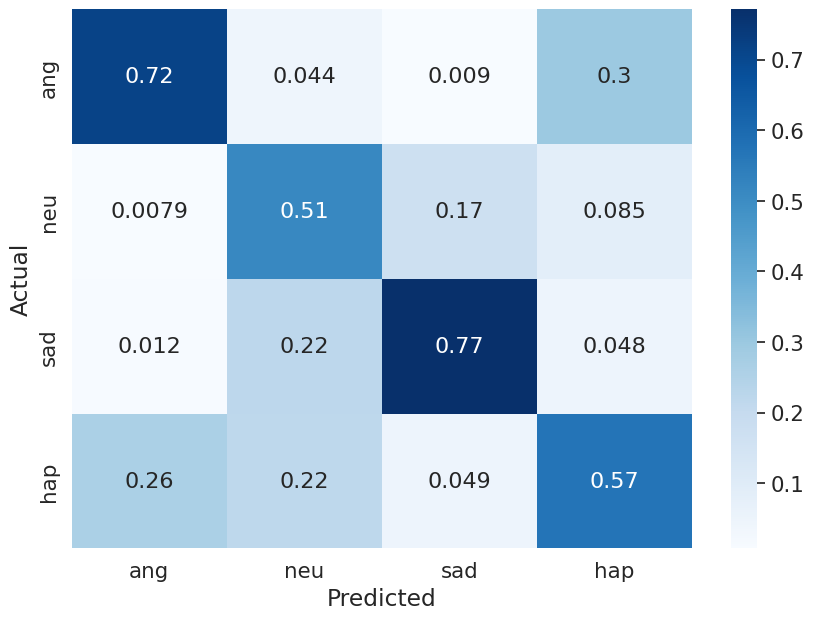

In [24]:
labels = dataset_config.target_labels
a = cm.detach().cpu()
# a /= reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

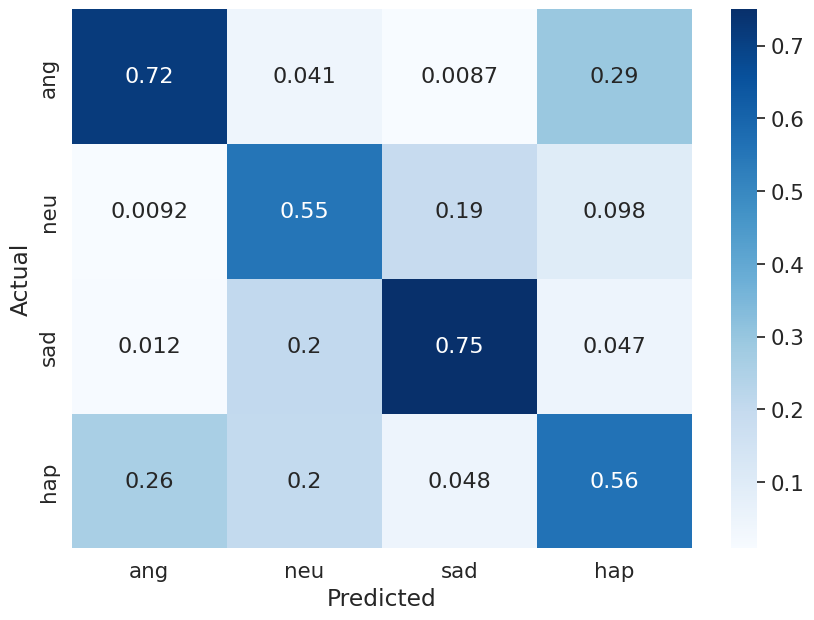

In [26]:
a = cm.detach().cpu()
a = a / reduce(a, 'y yh -> y 1', 'sum')
a /= reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [27]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
loss_df

,loss,perplexity,loss_vq,loss_recon,loss_cls
0,1.664568,0.0,0.0,0.0,1.664568
1,1.521773,0.0,0.0,0.0,1.521773
2,1.351074,0.0,0.0,0.0,1.351074
3,1.318958,0.0,0.0,0.0,1.318958
4,1.429563,0.0,0.0,0.0,1.429563
...,...,...,...,...,...
73495,0.008204,0.0,0.0,0.0,0.008204
73496,0.001054,0.0,0.0,0.0,0.001054
73497,0.000319,0.0,0.0,0.0,0.000319
73498,0.000700,0.0,0.0,0.0,0.000700


In [28]:
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

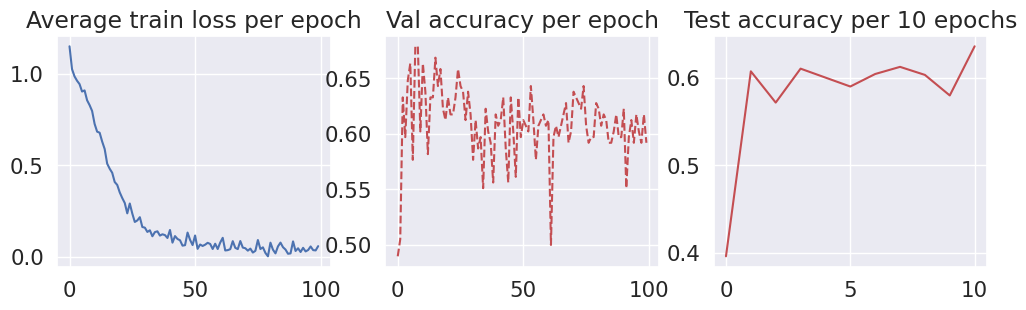

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [30]:
from scipy.signal import savgol_filter

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

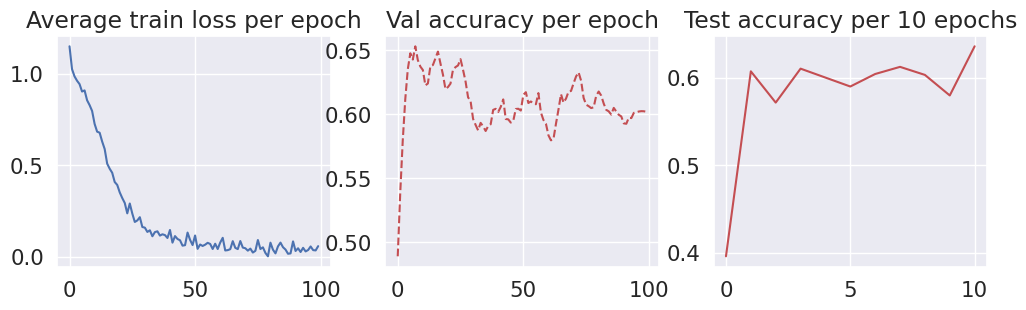

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [32]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")

In [36]:
iconnet_config = ocf.load(iconnet_config_path)
iconnet_config.fe.n_channel = [456]
iconnet_config.fe.window_k = [2]
iconnet_config.cls = {'n_block': 1, 'n_hidden_dim': [512,], 'norm_type': 'LayerNorm'}
print(iconnet_config)

{'name': 'M19', 'description': 'FirConv with learnable windows', 'fe': {'n_block': 1, 'n_channel': [456], 'kernel_size': [511], 'stride': [2], 'window_k': [2], 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': False, 'learnable_windows': True, 'shared_window': False, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'conv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 1, 'n_hidden_dim': [512], 'norm_type': 'LayerNorm'}}


In [37]:
codebook_pretrained_path = f'../scb7_models/crema_d/codebook.epoch=42.pt'
model = SCB(
    in_channels=in_channels,
    out_channels=out_channels,
    num_embeddings=num_embeddings, 
    embedding_dim=embedding_dim, 
    num_tokens=num_tokens,
    num_classes=num_classes, 
    cls_dim=embedding_dim,
    sample_rate=16000,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    loss_type='signal_loss',
    iconnet_config=iconnet_config,
)

In [38]:
trainer.setup(model=model, lr=learning_rate)

In [39]:
trainer.fit(n_epoch=100, self_supervised=False, train_task='embedding', test_n_epoch=10)

  0%|▍                                                                               | 0.4771622934888197/100 [04:35<237:30:25, 8591.25s/it]

Epoch: 1	Loss: 0.189 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.189]	Val_acc: 96/196 (48.98%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=1.step=368.loss=0.189.val_acc=0.490.pt


  1%|█▏                                                                                  | 1.428571428571455/100 [11:04<8:03:23, 294.24s/it]

Correct: 536/980 (0.5469)
Saved new best test model: ../scb16_models/crema_d/model.epoch=1.step=735.test_acc=0.5469.pt
{'acc_unweighted': tensor(0.5438, device='cuda:0'),
 'acc_weighted': tensor(0.5469, device='cuda:0'),
 'f1s_unweighted': tensor(0.5099, device='cuda:0'),
 'f1s_weighted': tensor(0.5130, device='cuda:0'),
 'rocauc': tensor(0.8299, device='cuda:0'),
 'uar': tensor(0.5438, device='cuda:0'),
 'wap': tensor(0.5212, device='cuda:0')}
{'acc_detail': tensor([0.7598, 0.4587, 0.8031, 0.1535], device='cuda:0'),
 'f1s_detail': tensor([0.6918, 0.4255, 0.6974, 0.2248], device='cuda:0'),
 'precision_detail': tensor([0.6349, 0.3968, 0.6163, 0.4194], device='cuda:0'),
 'recall_detail': tensor([0.7598, 0.4587, 0.8031, 0.1535], device='cuda:0'),
 'rocauc_detail': tensor([0.9001, 0.7774, 0.9032, 0.7391], device='cuda:0')}
tensor([[193,  24,   5,  32],
        [ 10, 100,  93,  15],
        [  4,  39, 204,   7],
        [ 97,  89,  29,  39]], device='cuda:0')


  2%|█▌                                                                              | 1.9057337220602952/100 [15:41<235:47:06, 8653.17s/it]

Epoch: 2	Loss: 0.702 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.702]	Val_acc: 124/196 (63.27%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=2.step=1103.loss=0.702.val_acc=0.633.pt


  3%|██▎                                                                             | 2.8581146744412798/100 [24:28<234:28:06, 8689.21s/it]

Epoch: 3	Loss: 0.486 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.486]	Val_acc: 131/196 (66.84%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=3.step=1838.loss=0.486.val_acc=0.668.pt


  4%|███                                                                             | 3.8104956268222643/100 [33:18<233:13:44, 8728.86s/it]

Epoch: 4	Loss: 0.656 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.656]	Val_acc: 120/196 (61.22%)



  5%|███▊                                                                             | 4.762876579203248/100 [42:09<232:09:23, 8775.61s/it]

Epoch: 5	Loss: 1.037 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.037]	Val_acc: 131/196 (66.84%)



  6%|████▋                                                                            | 5.715257531584233/100 [50:57<228:01:49, 8706.71s/it]

Epoch: 6	Loss: 0.617 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.617]	Val_acc: 123/196 (62.76%)



  7%|█████▍                                                                           | 6.667638483965217/100 [59:45<224:36:46, 8663.73s/it]

Epoch: 7	Loss: 0.007 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.007]	Val_acc: 127/196 (64.80%)



  8%|██████                                                                         | 7.620019436346202/100 [1:08:31<225:12:52, 8776.49s/it]

Epoch: 8	Loss: 1.426 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.426]	Val_acc: 126/196 (64.29%)



  9%|██████▊                                                                        | 8.572400388727186/100 [1:17:27<235:12:46, 9261.60s/it]

Epoch: 9	Loss: 1.504 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.504]	Val_acc: 129/196 (65.82%)



 10%|███████▌                                                                        | 9.52478134110817/100 [1:26:26<216:31:09, 8615.29s/it]

Epoch: 10	Loss: 0.368 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.368]	Val_acc: 128/196 (65.31%)



 10%|████████▏                                                                     | 10.477162293489155/100 [1:35:13<216:56:56, 8724.22s/it]

Epoch: 11	Loss: 0.421 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.421]	Val_acc: 120/196 (61.22%)



 11%|█████████▎                                                                       | 11.428571428571791/100 [1:41:48<7:30:10, 304.95s/it]

Correct: 623/980 (0.6357)
Saved new best test model: ../scb16_models/crema_d/model.epoch=11.step=8085.test_acc=0.6357.pt
{'acc_unweighted': tensor(0.6411, device='cuda:0'),
 'acc_weighted': tensor(0.6357, device='cuda:0'),
 'f1s_unweighted': tensor(0.6342, device='cuda:0'),
 'f1s_weighted': tensor(0.6351, device='cuda:0'),
 'rocauc': tensor(0.8685, device='cuda:0'),
 'uar': tensor(0.6411, device='cuda:0'),
 'wap': tensor(0.6608, device='cuda:0')}
{'acc_detail': tensor([0.7008, 0.7890, 0.6417, 0.4331], device='cuda:0'),
 'f1s_detail': tensor([0.7106, 0.6099, 0.7165, 0.5000], device='cuda:0'),
 'precision_detail': tensor([0.7206, 0.4971, 0.8109, 0.5914], device='cuda:0'),
 'recall_detail': tensor([0.7008, 0.7890, 0.6417, 0.4331], device='cuda:0'),
 'rocauc_detail': tensor([0.9077, 0.8525, 0.9139, 0.8000], device='cuda:0')}
tensor([[178,  19,   2,  55],
        [  4, 172,  29,  13],
        [  4,  79, 163,   8],
        [ 61,  76,   7, 110]], device='cuda:0')


 12%|█████████▎                                                                    | 11.905733722060631/100 [1:46:26<212:44:47, 8693.96s/it]

Epoch: 12	Loss: 0.382 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.382]	Val_acc: 132/196 (67.35%)

Saved new best val model: ../scb16_models/crema_d/model.epoch=12.step=8453.loss=0.382.val_acc=0.673.pt


 13%|██████████                                                                    | 12.858114674441616/100 [1:55:19<210:57:20, 8714.99s/it]

Epoch: 13	Loss: 0.206 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.206]	Val_acc: 129/196 (65.82%)



 14%|███████████                                                                     | 13.8104956268226/100 [2:04:07<208:19:36, 8701.48s/it]

Epoch: 14	Loss: 0.192 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.192]	Val_acc: 123/196 (62.76%)



 15%|███████████▌                                                                  | 14.762876579203585/100 [2:13:01<208:37:46, 8811.50s/it]

Epoch: 15	Loss: 1.012 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=1.012]	Val_acc: 123/196 (62.76%)



 16%|████████████▍                                                                  | 15.71525753158457/100 [2:21:52<205:42:41, 8786.42s/it]

Epoch: 16	Loss: 0.089 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.089]	Val_acc: 125/196 (63.78%)



 17%|█████████████                                                                 | 16.667638483964332/100 [2:30:49<205:38:21, 8883.72s/it]

Epoch: 17	Loss: 0.318 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.318]	Val_acc: 128/196 (65.31%)



 18%|█████████████▋                                                                | 17.620019436343576/100 [2:39:44<199:29:26, 8717.73s/it]

Epoch: 18	Loss: 0.038 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.038]	Val_acc: 127/196 (64.80%)



 19%|██████████████▋                                                                | 18.57240038872282/100 [2:48:42<200:54:03, 8882.05s/it]

Epoch: 19	Loss: 0.006 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.006]	Val_acc: 123/196 (62.76%)



 20%|███████████████▏                                                              | 19.524781341102063/100 [2:57:37<195:47:41, 8758.74s/it]

Epoch: 20	Loss: 0.020 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.020]	Val_acc: 126/196 (64.29%)



 20%|███████████████▉                                                              | 20.477162293481307/100 [3:06:27<194:58:19, 8826.39s/it]

Epoch: 21	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 127/196 (64.80%)



 21%|█████████████████▎                                                               | 21.428571428562204/100 [3:13:04<6:38:26, 304.26s/it]

Correct: 605/980 (0.6173)
{'acc_unweighted': tensor(0.6108, device='cuda:0'),
 'acc_weighted': tensor(0.6173, device='cuda:0'),
 'f1s_unweighted': tensor(0.6108, device='cuda:0'),
 'f1s_weighted': tensor(0.6150, device='cuda:0'),
 'rocauc': tensor(0.8558, device='cuda:0'),
 'uar': tensor(0.6108, device='cuda:0'),
 'wap': tensor(0.6253, device='cuda:0')}
{'acc_detail': tensor([0.6181, 0.4312, 0.7756, 0.6181], device='cuda:0'),
 'f1s_detail': tensor([0.6709, 0.4960, 0.7243, 0.5518], device='cuda:0'),
 'precision_detail': tensor([0.7336, 0.5839, 0.6793, 0.4984], device='cuda:0'),
 'recall_detail': tensor([0.6181, 0.4312, 0.7756, 0.6181], device='cuda:0'),
 'rocauc_detail': tensor([0.8929, 0.8359, 0.9066, 0.7877], device='cuda:0')}
tensor([[157,  10,   7,  80],
        [  5,  94,  65,  54],
        [  3,  30, 197,  24],
        [ 49,  27,  21, 157]], device='cuda:0')


 22%|█████████████████                                                             | 21.905733722050172/100 [3:17:42<190:24:01, 8777.10s/it]

Epoch: 22	Loss: 0.148 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.148]	Val_acc: 120/196 (61.22%)



 23%|█████████████████▊                                                            | 22.858114674429416/100 [3:26:34<188:46:40, 8809.74s/it]

Epoch: 23	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 125/196 (63.78%)



 24%|██████████████████▊                                                            | 23.81049562680866/100 [3:35:24<185:41:07, 8773.74s/it]

Epoch: 24	Loss: 0.336 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.336]	Val_acc: 120/196 (61.22%)



 25%|███████████████████▎                                                          | 24.762876579187903/100 [3:44:16<182:32:26, 8734.34s/it]

Epoch: 25	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 123/196 (62.76%)



 26%|████████████████████                                                          | 25.715257531567147/100 [3:53:07<181:46:23, 8809.13s/it]

Epoch: 26	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 129/196 (65.82%)



 27%|█████████████████████                                                          | 26.66763848394639/100 [4:02:00<178:54:36, 8782.98s/it]

Epoch: 27	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 124/196 (63.27%)



 28%|█████████████████████▌                                                        | 27.620019436325634/100 [4:10:54<176:56:53, 8800.96s/it]

Epoch: 28	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 122/196 (62.24%)



 29%|██████████████████████▎                                                       | 28.572400388704878/100 [4:19:45<175:18:15, 8835.46s/it]

Epoch: 29	Loss: 0.002 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.002]	Val_acc: 122/196 (62.24%)



 30%|███████████████████████                                                       | 29.524781341084122/100 [4:28:35<172:57:57, 8835.41s/it]

Epoch: 30	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 124/196 (63.27%)



 30%|███████████████████████▊                                                      | 30.477162293463365/100 [4:37:27<170:30:23, 8829.09s/it]

Epoch: 31	Loss: 0.008 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.008]	Val_acc: 117/196 (59.69%)



 31%|█████████████████████████▍                                                       | 31.428571428544263/100 [4:44:05<5:50:25, 306.63s/it]

Correct: 613/980 (0.6255)
{'acc_unweighted': tensor(0.6268, device='cuda:0'),
 'acc_weighted': tensor(0.6255, device='cuda:0'),
 'f1s_unweighted': tensor(0.6165, device='cuda:0'),
 'f1s_weighted': tensor(0.6176, device='cuda:0'),
 'rocauc': tensor(0.8518, device='cuda:0'),
 'uar': tensor(0.6268, device='cuda:0'),
 'wap': tensor(0.6262, device='cuda:0')}
{'acc_detail': tensor([0.7441, 0.6606, 0.7244, 0.3780], device='cuda:0'),
 'f1s_detail': tensor([0.6987, 0.5866, 0.7202, 0.4604], device='cuda:0'),
 'precision_detail': tensor([0.6585, 0.5275, 0.7160, 0.5890], device='cuda:0'),
 'recall_detail': tensor([0.7441, 0.6606, 0.7244, 0.3780], device='cuda:0'),
 'rocauc_detail': tensor([0.8914, 0.8380, 0.9044, 0.7733], device='cuda:0')}
tensor([[189,  17,   4,  44],
        [ 11, 144,  49,  14],
        [  8,  53, 184,   9],
        [ 79,  59,  20,  96]], device='cuda:0')


 32%|█████████████████████████▏                                                     | 31.90573372203223/100 [4:48:45<168:28:16, 8906.72s/it]

Epoch: 32	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 125/196 (63.78%)



 33%|█████████████████████████▉                                                     | 32.85811467441461/100 [4:57:38<167:02:29, 8956.40s/it]

Epoch: 33	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 129/196 (65.82%)



 34%|██████████████████████████▎                                                   | 33.810495626797334/100 [5:06:31<163:31:50, 8894.31s/it]

Epoch: 34	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 130/196 (66.33%)



 35%|███████████████████████████▍                                                   | 34.76287657918006/100 [5:15:25<159:47:56, 8818.25s/it]

Epoch: 35	Loss: 0.101 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.101]	Val_acc: 110/196 (56.12%)



 36%|███████████████████████████▊                                                  | 35.715257531562784/100 [5:24:18<158:50:51, 8895.61s/it]

Epoch: 36	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 121/196 (61.73%)



 37%|████████████████████████████▉                                                  | 36.66763848394551/100 [5:33:14<155:46:32, 8854.75s/it]

Epoch: 37	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 126/196 (64.29%)



 38%|█████████████████████████████▎                                                | 37.620019436328235/100 [5:42:06<154:58:21, 8943.60s/it]

Epoch: 38	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 119/196 (60.71%)



 39%|██████████████████████████████▍                                                | 38.57240038871096/100 [5:51:00<151:37:09, 8885.74s/it]

Epoch: 39	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 125/196 (63.78%)



 40%|██████████████████████████████▊                                               | 39.524781341093686/100 [5:59:53<150:13:21, 8942.53s/it]

Epoch: 40	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 123/196 (62.76%)



 40%|███████████████████████████████▉                                               | 40.47716229347641/100 [6:08:46<147:29:44, 8920.68s/it]

Epoch: 41	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 127/196 (64.80%)



 41%|█████████████████████████████████▉                                                | 41.42857142856079/100 [6:15:27<5:00:21, 307.68s/it]

Correct: 591/980 (0.6031)
{'acc_unweighted': tensor(0.5949, device='cuda:0'),
 'acc_weighted': tensor(0.6031, device='cuda:0'),
 'f1s_unweighted': tensor(0.5908, device='cuda:0'),
 'f1s_weighted': tensor(0.5957, device='cuda:0'),
 'rocauc': tensor(0.8470, device='cuda:0'),
 'uar': tensor(0.5949, device='cuda:0'),
 'wap': tensor(0.6086, device='cuda:0')}
{'acc_detail': tensor([0.6496, 0.3716, 0.8150, 0.5433], device='cuda:0'),
 'f1s_detail': tensor([0.6904, 0.4563, 0.7053, 0.5111], device='cuda:0'),
 'precision_detail': tensor([0.7366, 0.5912, 0.6216, 0.4825], device='cuda:0'),
 'recall_detail': tensor([0.6496, 0.3716, 0.8150, 0.5433], device='cuda:0'),
 'rocauc_detail': tensor([0.8825, 0.8377, 0.9034, 0.7645], device='cuda:0')}
tensor([[165,   6,   8,  75],
        [  4,  81,  80,  53],
        [  2,  25, 207,  20],
        [ 53,  25,  38, 138]], device='cuda:0')


 42%|█████████████████████████████████▌                                              | 41.9057337220505/100 [6:20:09<143:13:40, 8875.59s/it]

Epoch: 42	Loss: 0.001 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.001]	Val_acc: 124/196 (63.27%)



 43%|█████████████████████████████████▍                                            | 42.858114674433224/100 [6:29:02<141:28:38, 8913.22s/it]

Epoch: 43	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 125/196 (63.78%)



 44%|██████████████████████████████████▌                                            | 43.81049562681595/100 [6:37:56<138:50:24, 8895.34s/it]

Epoch: 44	Loss: 0.016 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.016]	Val_acc: 116/196 (59.18%)



 45%|██████████████████████████████████▉                                           | 44.762876579198675/100 [6:46:53<136:52:30, 8920.63s/it]

Epoch: 45	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 126/196 (64.29%)



 46%|████████████████████████████████████▌                                           | 45.7152575315814/100 [6:55:46<133:02:04, 8822.46s/it]

Epoch: 46	Loss: 0.316 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.316]	Val_acc: 128/196 (65.31%)



 47%|████████████████████████████████████▍                                         | 46.667638483964126/100 [7:04:41<131:53:40, 8903.04s/it]

Epoch: 47	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 126/196 (64.29%)



 48%|█████████████████████████████████████▌                                         | 47.62001943634685/100 [7:13:33<130:04:02, 8939.35s/it]

Epoch: 48	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 129/196 (65.82%)



 49%|██████████████████████████████████████▎                                        | 48.57240038872958/100 [7:22:28<128:11:19, 8973.39s/it]

Epoch: 49	Loss: 0.908 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.908]	Val_acc: 124/196 (63.27%)



 50%|███████████████████████████████████████▌                                        | 49.5247813411123/100 [7:31:24<126:09:54, 8998.36s/it]

Epoch: 50	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 117/196 (59.69%)



 50%|███████████████████████████████████████▉                                       | 50.47716229349503/100 [7:40:22<124:48:53, 9073.25s/it]

Epoch: 51	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 124/196 (63.27%)



 51%|██████████████████████████████████████████▋                                        | 51.4285714285794/100 [7:47:06<4:12:44, 312.21s/it]

Correct: 578/980 (0.5898)
{'acc_unweighted': tensor(0.5894, device='cuda:0'),
 'acc_weighted': tensor(0.5898, device='cuda:0'),
 'f1s_unweighted': tensor(0.5826, device='cuda:0'),
 'f1s_weighted': tensor(0.5837, device='cuda:0'),
 'rocauc': tensor(0.8357, device='cuda:0'),
 'uar': tensor(0.5894, device='cuda:0'),
 'wap': tensor(0.6192, device='cuda:0')}
{'acc_detail': tensor([0.3937, 0.5780, 0.8031, 0.5827], device='cuda:0'),
 'f1s_detail': tensor([0.5263, 0.5538, 0.7208, 0.5295], device='cuda:0'),
 'precision_detail': tensor([0.7937, 0.5316, 0.6538, 0.4852], device='cuda:0'),
 'recall_detail': tensor([0.3937, 0.5780, 0.8031, 0.5827], device='cuda:0'),
 'rocauc_detail': tensor([0.8885, 0.7902, 0.8971, 0.7671], device='cuda:0')}
tensor([[100,  22,   9, 123],
        [  0, 126,  68,  24],
        [  1,  39, 204,  10],
        [ 25,  50,  31, 148]], device='cuda:0')


 52%|████████████████████████████████████████▍                                     | 51.905733722069115/100 [7:51:48<119:51:47, 8972.13s/it]

Epoch: 52	Loss: 0.045 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.045]	Val_acc: 110/196 (56.12%)



 53%|█████████████████████████████████████████▊                                     | 52.85811467445184/100 [8:00:45<117:19:31, 8959.59s/it]

Epoch: 53	Loss: 0.000 [perplexity=0.000, loss_vq=0.000, loss_recon=0.000, loss_cls=0.000]	Val_acc: 124/196 (63.27%)



 54%|████████████████████████████████████████████                                      | 53.78620019437582/100 [8:09:26<7:00:32, 545.99s/it]

KeyboardInterrupt



In [40]:
trainer.load_best_model(val_model=True)

Loaded: ../scb16_models/crema_d/model.epoch=12.step=8453.loss=0.382.val_acc=0.673.pt


In [44]:
metrics, metrics_details, confusion_matrix = trainer.test_step()

Correct: 628/980 (0.6408)
Saved new best test model: ../scb16_models/crema_d/model.epoch=54.step=39304.test_acc=0.6408.pt


In [45]:
me = metrics.cpu().compute()
med = metrics_details.cpu().compute()
cm = confusion_matrix.cpu().compute()

In [46]:
pprint(me)
pprint(med)
pprint(cm)

{'acc_unweighted': tensor(0.6423),
 'acc_weighted': tensor(0.6408),
 'f1s_unweighted': tensor(0.6367),
 'f1s_weighted': tensor(0.6383),
 'rocauc': tensor(0.8699),
 'uar': tensor(0.6423),
 'wap': tensor(0.6528)}
{'acc_detail': tensor([0.7992, 0.6835, 0.6299, 0.4567]),
 'f1s_detail': tensor([0.7342, 0.5924, 0.7033, 0.5167]),
 'precision_detail': tensor([0.6789, 0.5228, 0.7960, 0.5949]),
 'recall_detail': tensor([0.7992, 0.6835, 0.6299, 0.4567]),
 'rocauc_detail': tensor([0.9109, 0.8614, 0.9176, 0.7896])}
tensor([[203,  13,   2,  36],
        [  9, 149,  33,  27],
        [  9,  69, 160,  16],
        [ 78,  54,   6, 116]])


<Axes: xlabel='Predicted', ylabel='Actual'>

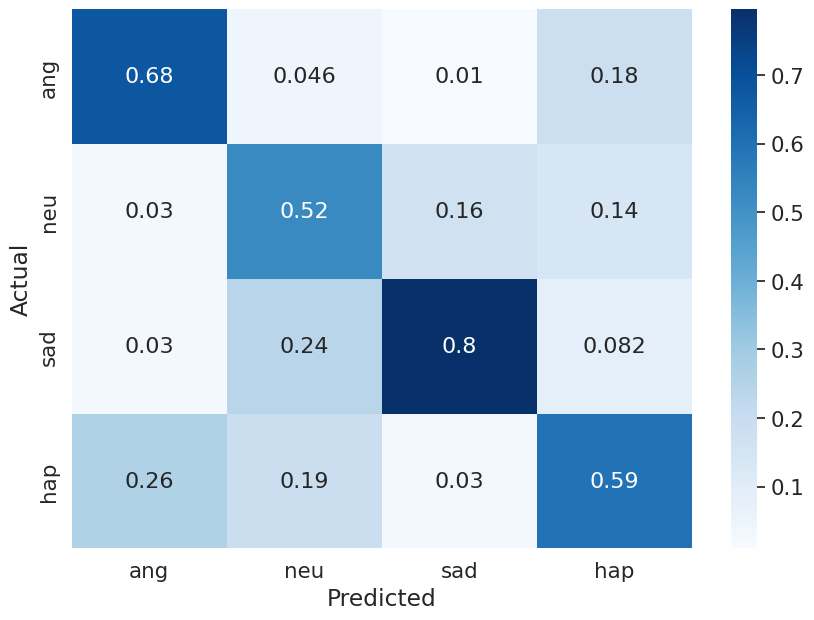

In [49]:
labels = dataset_config.target_labels
# a /= reduce(a, 'y yh -> y 1', 'sum')
a = cm
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

<Axes: xlabel='Predicted', ylabel='Actual'>

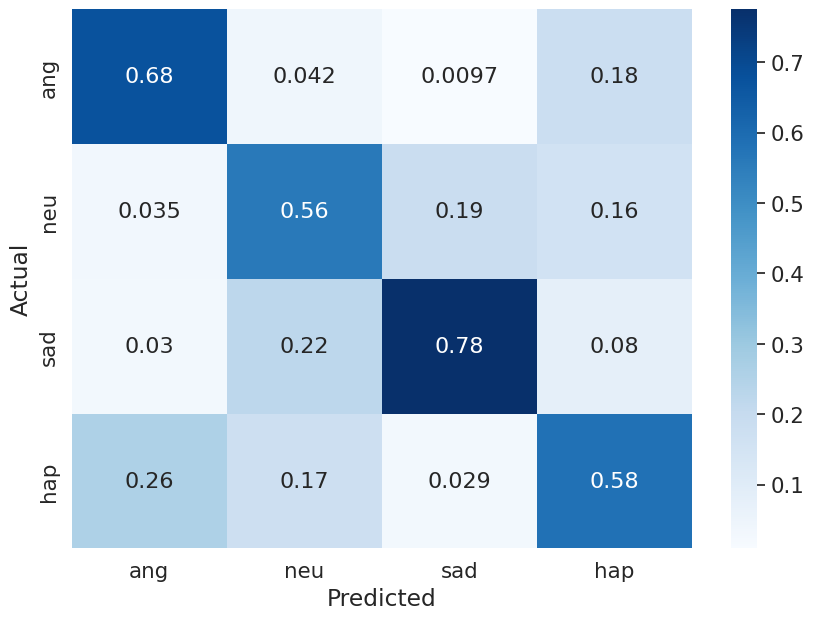

In [50]:
a = cm
a = a / reduce(a, 'y yh -> y 1', 'sum')
a = a / reduce(a, 'y yh -> 1 yh', 'sum')
df_cm = pd.DataFrame(a, columns=labels, index = labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(
    df_cm, cmap="Blues", 
    annot=True,
    annot_kws={"size": 16})# font size

In [51]:
dt = []
for i, ld in enumerate(trainer.train_losses_detail):
    d = {'loss': trainer.train_losses[i]}
    for j, k in enumerate(ld._fields):
        d[k] = ld[j]
    dt.append(d)
loss_df = pd.DataFrame(dt)
trained_epoch = trainer.current_epoch
n = len(trainer.train_losses)
trained_steps = n - (n % trained_epoch)
train_losses = reduce(np.array(
    trainer.train_losses[:trained_steps]), '(n k) -> n', 'mean', n=trained_epoch)

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

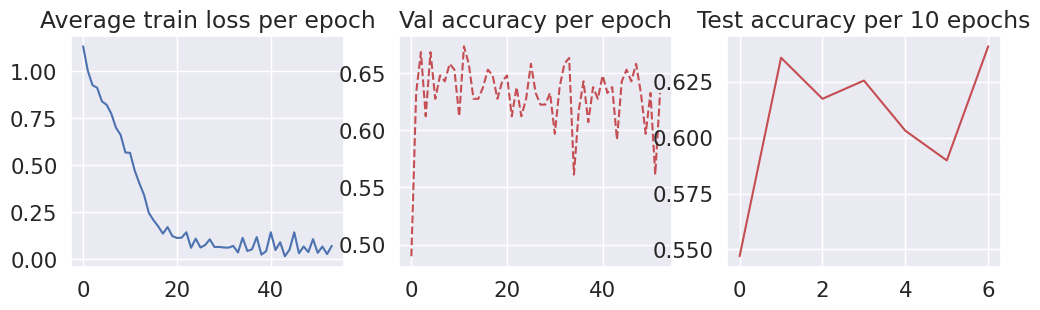

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(trainer.val_accuracy, color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

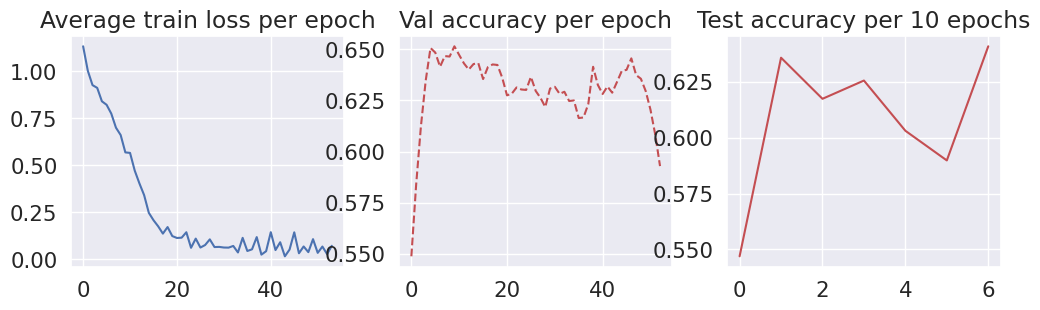

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy, color="r")
axes[2].set_title("Test accuracy per 10 epochs")

Text(0.5, 1.0, 'Test accuracy per 10 epochs')

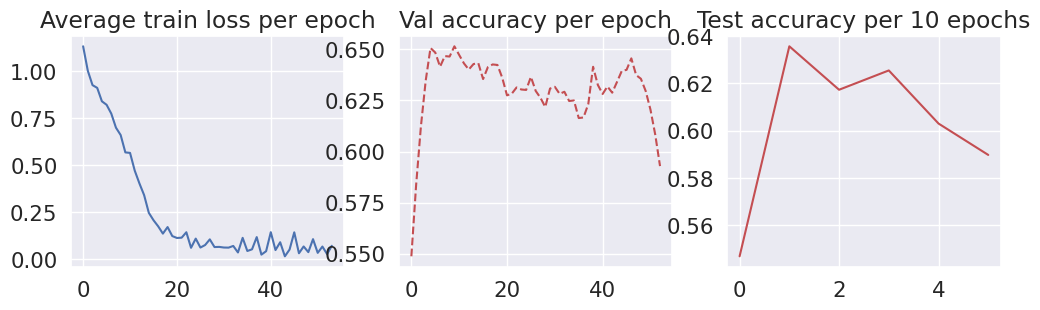

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].plot(train_losses, color="b")
axes[0].set_title("Average train loss per epoch")
axes[1].plot(savgol_filter(trainer.val_accuracy, 10, 2), color="r", linestyle="dashed")
axes[1].set_title("Val accuracy per epoch")
axes[2].plot(trainer.test_accuracy[:-1], color="r")
axes[2].set_title("Test accuracy per 10 epochs")

In [55]:
train_log = {
    'train_loss': torch.tensor(train_losses),
    'val_acc': torch.tensor(trainer.val_accuracy),
    'test_acc': torch.tensor(trainer.test_accuracy),
    'test_confusion_matrix': cm,
    'test_metrics': me,
    'test_metrics_detail': med,
    'best_model_path': '../scb16_models/crema_d/model.epoch=54.step=39304.test_acc=0.6408.pt'
}
torch.save(train_log, log_dir+"train_metrics.pt")
loss_df.to_csv(log_dir+"train_losses.csv")